
# Radio Processing Examples using PyRTLSDR
A Python wrapper for librtlsdr (a driver for Realtek RTL2832U based SDR's)
From: https://pypi.org/project/pyrtlsdr/
By Jon Munson
  ![](https://stopmensonges.com/wp-content/uploads/2016/04/sound-waves.jpg)

*This example shows*
* Using the RtlSdr wrapper of librtlsdr to
    * enumerate devices
    * select a device and open it
    * set the sample rate, frequency, and gain
    * gather a certain amount of samples
* Using matplotlib to
    * dispay a spectrogram of the samples with pyplot.specgram
    * display the PSD (power spectral density) of the samples with plyplot.psd
* Using numpy to break out the complex number arrays
    * allows plotting the constellation with pyplot.scatter
    * demodulate the FM (using polar discriminator)
    * scale the 'volume'
* Using scipy.signal to:
    * create a low pass filter for the signal
    * decimate the sample to a working sample, and to the audio sample rate
    * apply a de-emphasis filter
  

In [1]:
from rtlsdr import RtlSdr
import time
start_time = time.time()
out_file = "wbfm-mono.raw"
out_type = "int16"

In [2]:
# Get a list of detected device serial numbers (str)
serial_numbers = RtlSdr.get_device_serial_addresses()
print(serial_numbers[0])

12345


In [3]:
# Find the device index for a given serial number
device_index = RtlSdr.get_device_index_by_serial(serial_numbers[0])
print(device_index)

0


In [4]:
# sdr = RtlSdr(device_index)
# Or pass the serial number directly:
sdr = RtlSdr(serial_number=serial_numbers[0])

In [5]:
# configure device
samp_rate = 2.4e6
center_freq = 102.5e6
sdr.sample_rate = samp_rate
sdr.center_freq = center_freq
sdr.gain = 'auto'

* read in samples, then close the device so it can be used by others....

In [6]:
samples = sdr.read_samples((256*1024)*20)
sdr.close()
samples

array([ 0.03529412-0.01176471j,  0.05098039-0.05098039j,
        0.05098039+0.00392157j, ...,  0.41176471-1.j        ,
        0.83529412-0.79607843j,  1.00000000-0.03529412j])

In [7]:
# includes core parts of numpy, matplotlib
import matplotlib.pyplot as plt

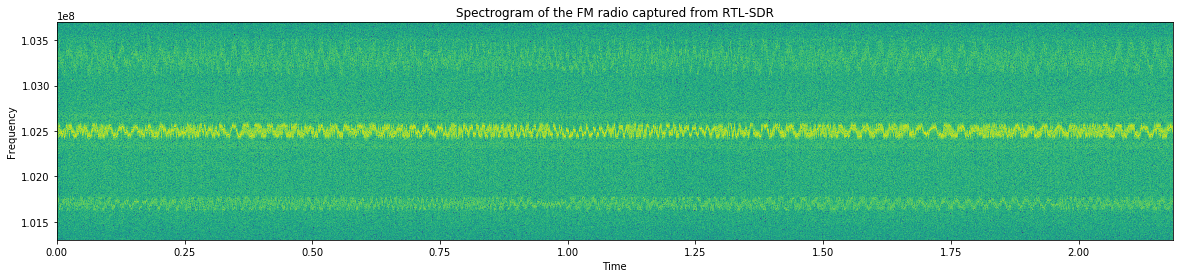

In [8]:
# Plot the spectogram of this data
plt.figure(figsize=(20, 4))
plt.specgram(samples, NFFT=(1024), Fs=samp_rate, Fc=center_freq) #,pad_to=1000
plt.title("Spectrogram of the FM radio captured from RTL-SDR")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.savefig("raw_fm_signal_spectrogram.pdf", bbox_inches='tight', pad_inches=0.5) 
plt.show()

The Power Spectral Density can shows the 'power' levels at particular frequencies

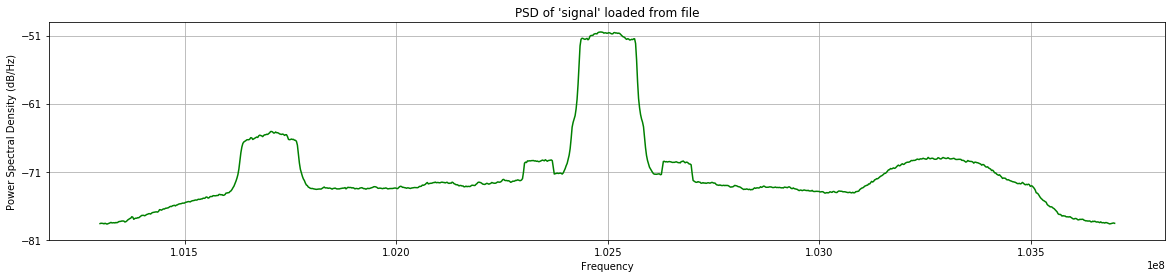

In [9]:
# Let's try a PSD plot of the same data
plt.figure(figsize=(20, 4))
plt.psd(samples, NFFT=1024, Fs=samp_rate, Fc=center_freq, color="green")
plt.title("PSD of 'signal' loaded from file")
plt.show()

numpy is now imported so the complex samples can be split into real and imaginary for plotting in a constellation

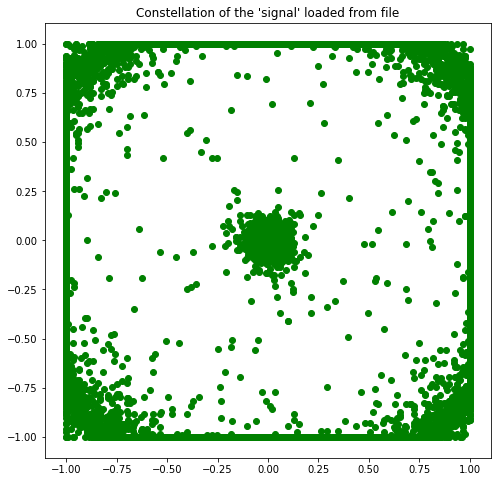

In [10]:
import numpy as np
plt.figure(figsize=(8,8))
plt.scatter(np.real(samples[0:10000]), np.imag(samples[0:10000]), color="green")
plt.title("Constellation of the 'signal' loaded from file")
plt.show()

Now, try to make a filter for the FM radio station, requiring scipy.signal

In [11]:
# another filter slution from: https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/
# include scipy's signal processing functions
import scipy.signal as signal
# An FM broadcast signal has  a bandwidth of 200 kHz
Fs  = samp_rate # sample_rate
f_bw = 200000  
n_taps = 64  
# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, f_bw, f_bw+(Fs/2-f_bw)/4, Fs/2], [1,0], Hz=Fs)  
new_samp = signal.lfilter(lpf, 1.0, samples)

In [12]:
# remix/ decimate the sample to a more workable rate
# This decimates the sample to a 'working' rate, smaller and faster
# An FM broadcast signal has  a bandwidth of 200 kHz
f_bw = 200000  
dec_rate = int(Fs / f_bw)  
working_samp = signal.decimate(new_samp, dec_rate)  
# Calculate the new sampling rate
working_samp_rate = Fs/dec_rate

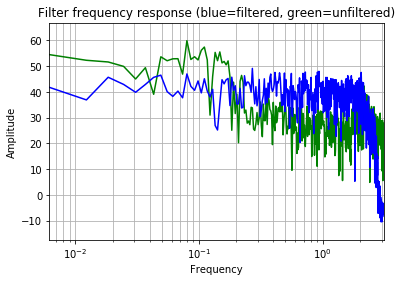

In [13]:
# Plot your filter's frequency response:
w, h = signal.freqz(working_samp[0:10000])
w2, h2 = signal.freqz(samples[0:10000])

plt.plot(w2, 20 * np.log10(abs(h2)), color="green") # unfiltered sample
plt.plot(w, 20 * np.log10(abs(h)), color="blue")    # The filtered sample
plt.xscale('log')
plt.title('Filter frequency response (blue=filtered, green=unfiltered)')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.savefig("freq_resonse_filtered_unfiltered.pdf", bbox_inches='tight', pad_inches=0.5) 
plt.show()

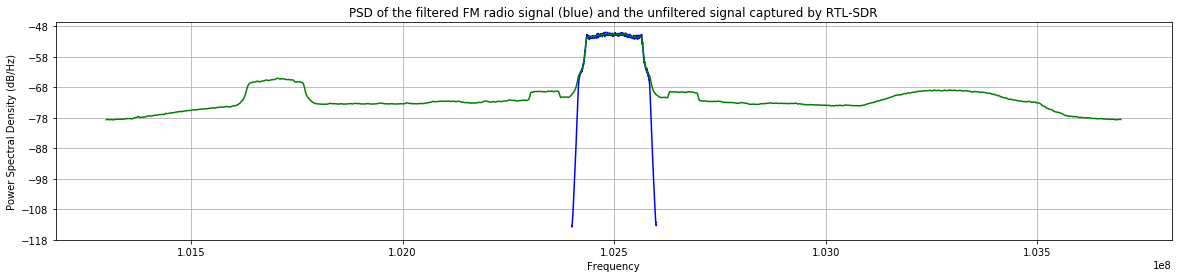

In [14]:
# Let's try a PSD plot of the working sample over the previous sample
plt.figure(figsize=(20, 4))
plt.psd(working_samp, NFFT=1024, Fs=working_samp_rate, Fc=center_freq, color="blue")
plt.psd(samples, NFFT=1024, Fs=samp_rate, Fc=center_freq, color="green")
plt.title("PSD of the filtered FM radio signal (blue) and the unfiltered signal captured by RTL-SDR")
plt.savefig("PSD_filtered_vs_unfiltered.pdf", bbox_inches='tight', pad_inches=0.5) 
plt.show()

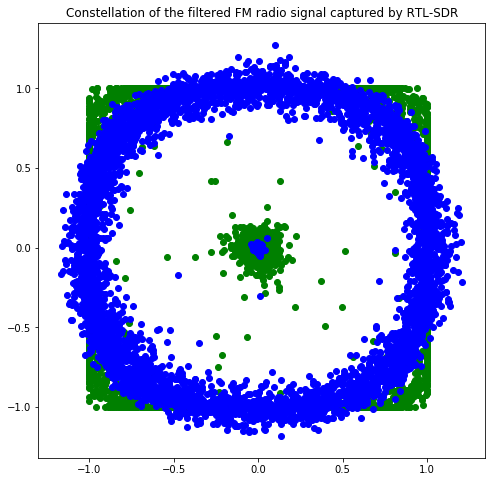

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(np.real(samples[0:5000]), np.imag(samples[0:5000]), color="green")
plt.scatter(np.real(working_samp[0:5000]), np.imag(working_samp[0:5000]), color="blue")
plt.title("Constellation of the filtered FM radio signal captured by RTL-SDR")
plt.savefig("working_samp_psd_highlighted.pdf", bbox_inches='tight', pad_inches=0.5) 
plt.show()

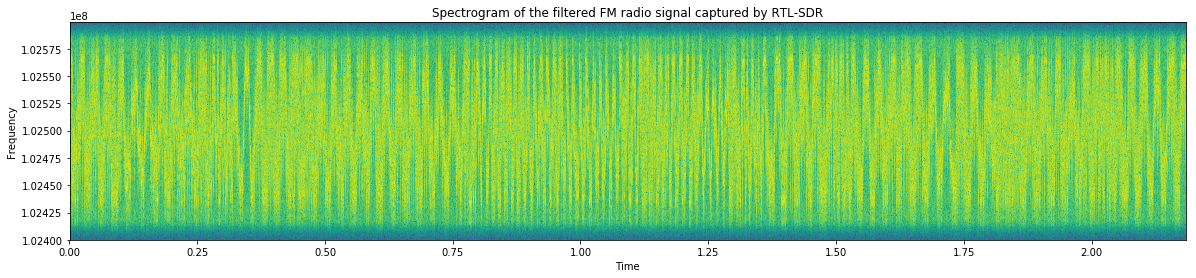

In [16]:
# Plot the spectogram of this data
plt.figure(figsize=(20, 4))
plt.specgram(working_samp, NFFT=int(1024/4), Fs=working_samp_rate, Fc=center_freq) #,pad_to=1000
plt.title("Spectrogram of the filtered FM radio signal captured by RTL-SDR")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.savefig("working_samp_filtered_spectrogram.pdf", bbox_inches='tight', pad_inches=0.5) 
plt.show()

In [17]:
# based on the blog: https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/
### Polar discriminator
y5 = working_samp[1:] * np.conj(working_samp[:-1])  
sig = np.angle(y5)  # an array of real, not complex, values

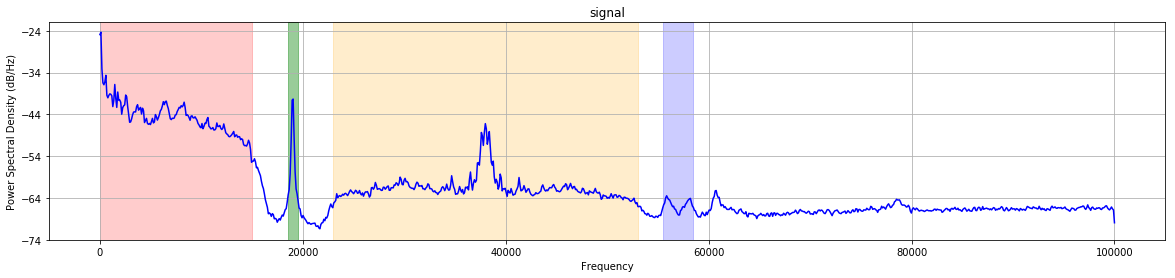

In [18]:
plt.figure(figsize=(20, 4))
plt.psd(sig, NFFT=2048, Fs=working_samp_rate, color="blue")  
plt.title("signal")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)    #
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  # 
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2) # 
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)   #
plt.ticklabel_format(style='plain', axis='y' )  
plt.savefig("working_samp_psd_highlighted.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()

In [19]:
# based on blog: https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/
# The de-emphasis filte
# Given a signal 'sig' (in a numpy array) with sampling rate working_samp_rate
d = working_samp_rate * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
deemph_sig = signal.lfilter(b,a,sig)

In [20]:
# based on blog: https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/
# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq = 44100.0  
dec_audio = int(working_samp_rate/audio_freq)  
Fs_audio = working_samp_rate / dec_audio

sig_audio = signal.decimate(deemph_sig, dec_audio)

In [21]:
# based on blog: https://witestlab.poly.edu/blog/capture-and-decode-fm-radio/
# Scale audio to adjust volume
sig_audio *= 10000 / np.max(np.abs(sig_audio))  
# Save to file as 16-bit signed single-channel audio samples
sig_audio.astype(out_type).tofile(out_file)

In [22]:
Fs_audio

50000.0

In [23]:
end_time = time.time()
print('total time',end_time-start_time)

total time 51.71430230140686


In [24]:
import IPython.display as display

In [25]:
display.Audio(data=sig_audio,rate=Fs_audio, autoplay=True)

In [30]:
sig_audio

array([  716.26031043,   246.79177841,  -331.59650139, ...,  7450.49382712,
        7284.39068514,  7313.12804941])